In [4]:
#!python3 -m spacy download en
import pysolr
import requests
import json
import pandas as pd
import os
from datetime import datetime

base_directory = os.getcwd()
print(base_directory)

# Setup a Solr instance. The timeout is optional.
solr = pysolr.Solr('http://pcalleja.oeg-upm.net/8983/solr/covid-sentences')

counter = 0
completed = False
window_size=1000
cursor = "*"
drugs={}
atc_code="bionlp_atc5_t"
while (not completed):
    old_counter = counter
    solr_query=atc_code+":[* TO *] AND scispacy_diseases_t:[* TO *]"
    try:
        sentences = solr.search(q=solr_query,rows=window_size,cursorMark=cursor,sort="id asc")
        cursor = sentences.nextCursorMark
        counter += len(sentences)
        for sentence in sentences:
            drugs_atc = sentence[atc_code].split(" ")
            symptoms = sentence['scispacy_diseases_t'].split(" ")
            for drug_atc in drugs_atc:
                if (not drug_atc in drugs):
                    drugs[drug_atc]=[]
                drugs[drug_atc].extend(symptoms)
        print("[",datetime.now(),"] sentences read! -",counter)
        if (old_counter == counter):
            print("done!")
            break
    except:
        print("Solr query error. Wait for 5secs..")
        time.sleep(5.0)

print(len(drugs),"unique drugs collected")        

/Users/cbadenes/Projects/librairy/public/covid19/atc-codes
[ 2020-04-04 14:12:47.827222 ] sentences read! - 1000
[ 2020-04-04 14:12:47.959727 ] sentences read! - 2000
[ 2020-04-04 14:12:48.091700 ] sentences read! - 3000
[ 2020-04-04 14:12:48.180409 ] sentences read! - 4000
[ 2020-04-04 14:12:48.285123 ] sentences read! - 5000
[ 2020-04-04 14:12:48.384075 ] sentences read! - 5908
[ 2020-04-04 14:12:48.410115 ] sentences read! - 5908
done!
1063 unique drugs collected


In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


corpus = []

for drug in drugs:
    symptoms = " ".join(drugs[drug])    
    corpus.append(symptoms)

#word_corpus = [' '.join(text) for text in df['abstract']]
#word_corpus = df['abstract'].to_list()

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=200000,
                                     min_df=0.0, use_idf=True)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(corpus) #fit the vectorizer to synopses

print(tfidf_matrix.shape)





CPU times: user 81 ms, sys: 2.9 ms, total: 83.9 ms
Wall time: 83.2 ms
(1063, 3504)


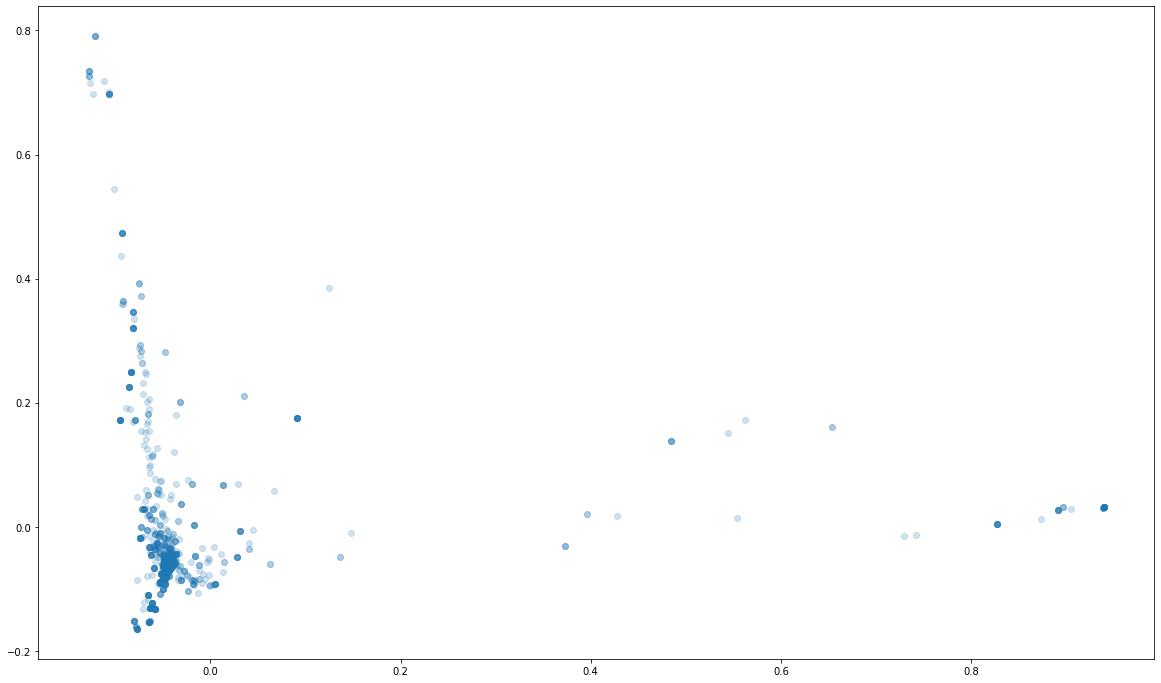

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_matrix = tfidf_matrix.todense()
pca.fit(x_matrix)
X = pca.transform(x_matrix)


fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)

#for i, txt in enumerate(df['title'].to_list()):
#    ax.annotate(txt, (X[:, 0][i], X[:, 1][i]))

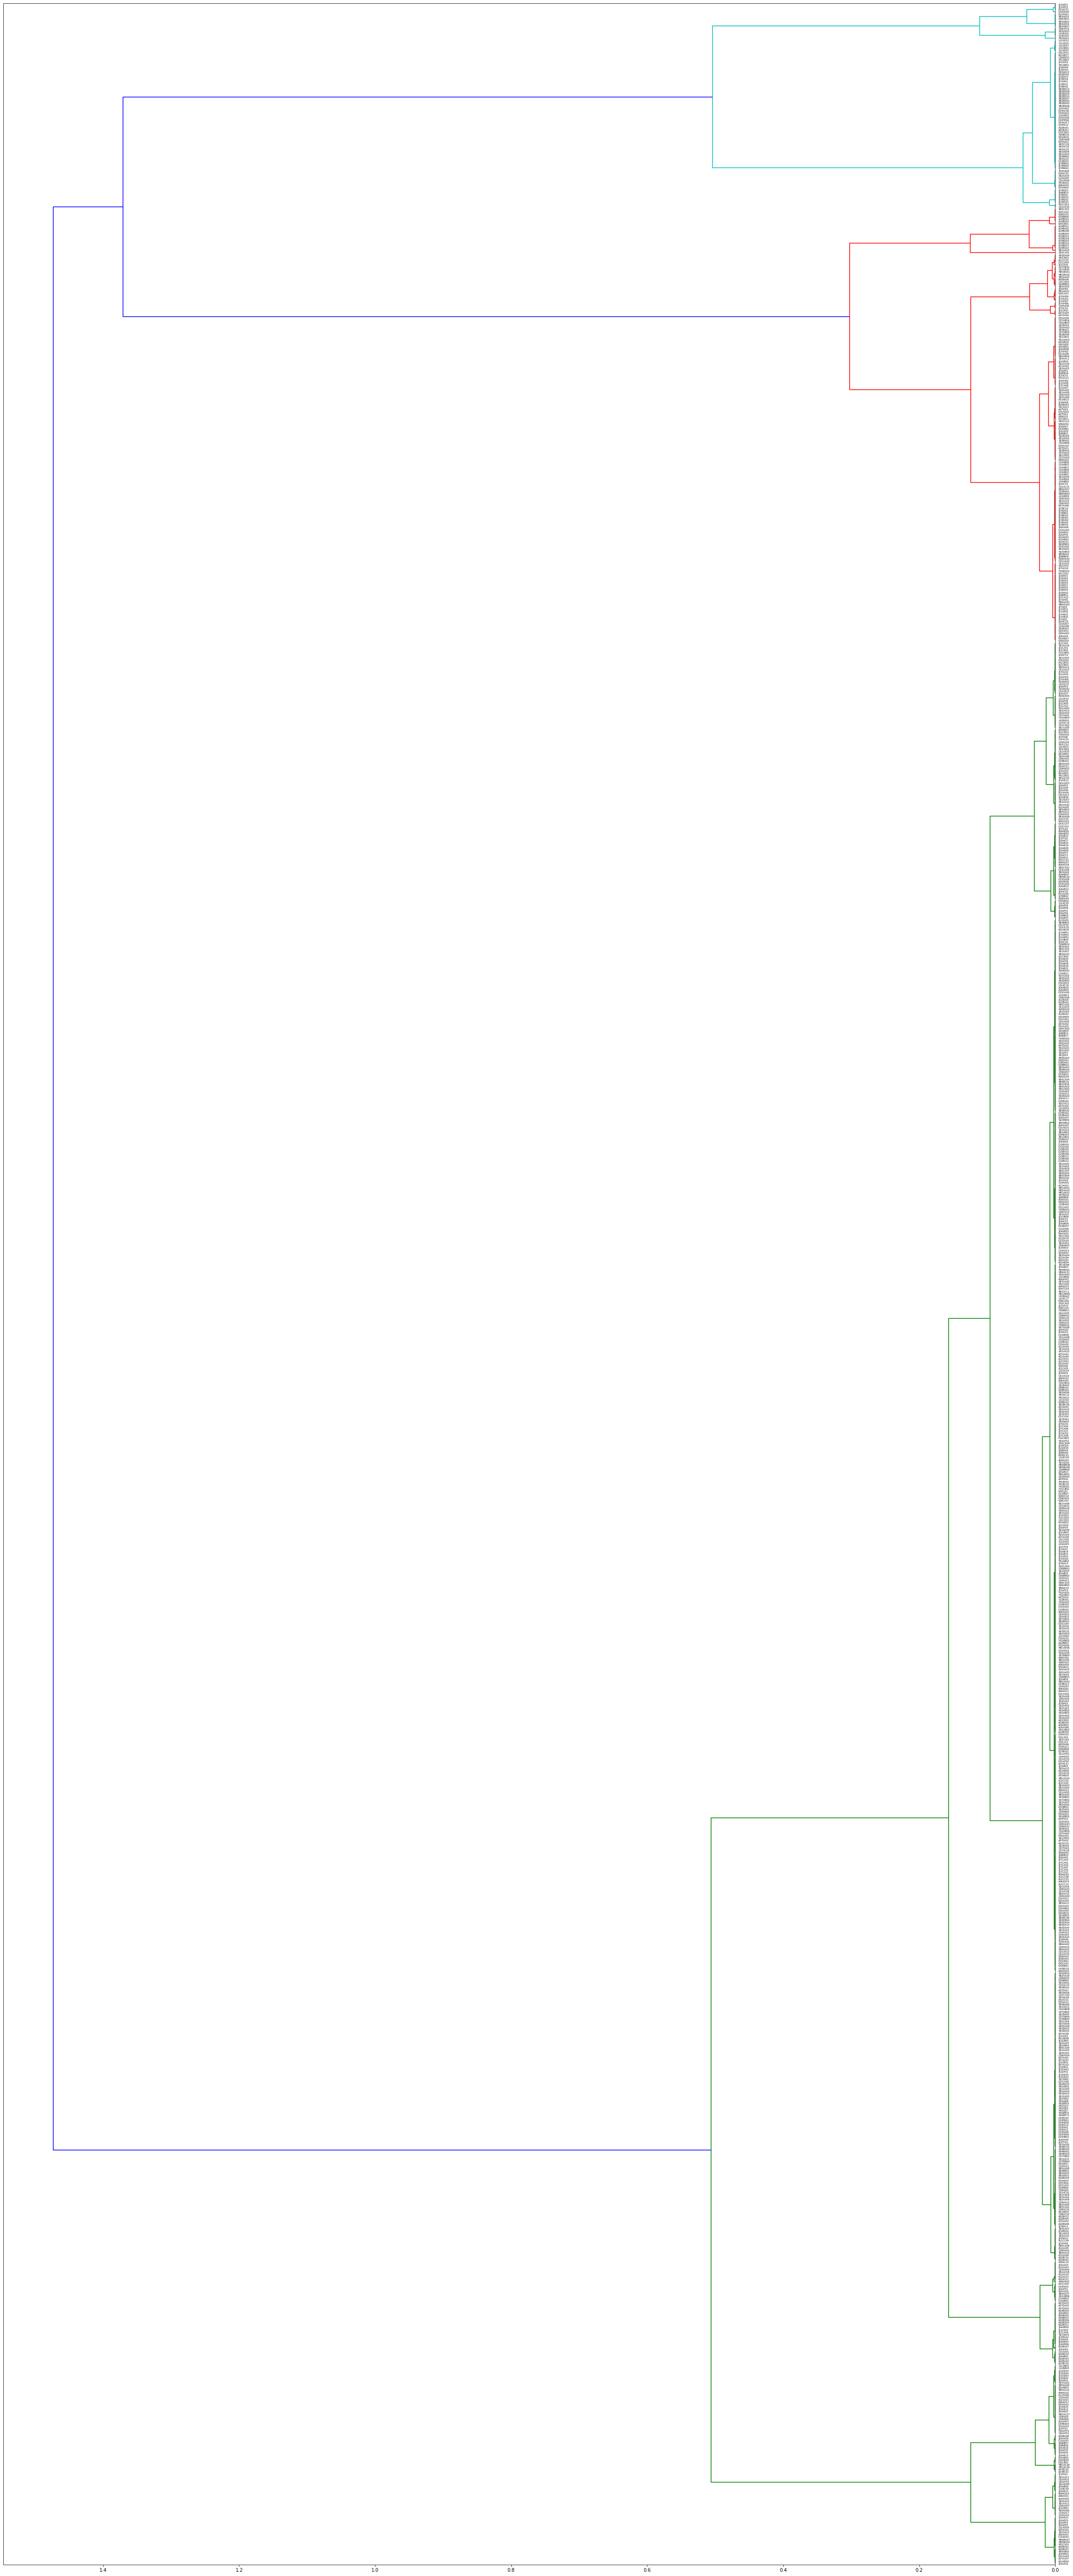

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

#  The distance function can be ‘braycurtis’, ‘canberra’, 
#‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, 
# ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, 
# ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

#dist = 1 - cosine_similarity(tfidf_matrix)
#MDS()
#mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
#pos = mds.fit_transform(tfidf_matrix.todense())  # shape (n_components, n_samples)

linked = linkage(X, 'average', 'cosine')
#linked = linkage(x_matrix, 'ward', 'euclidean')
#linked = linkage(X, 'ward', 'euclidean')

labelList = list(drugs.keys())

plt.figure(figsize=(40, 100))  
dendrogram(linked,  
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [17]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time clusters=km.fit_predict(X)
#%time clusters=km.fit_predict(x_matrix)

#clusters = km.labels_.tolist()

print(clusters)

CPU times: user 30.7 ms, sys: 1.59 ms, total: 32.3 ms
Wall time: 31 ms
[2 2 2 ... 0 0 0]


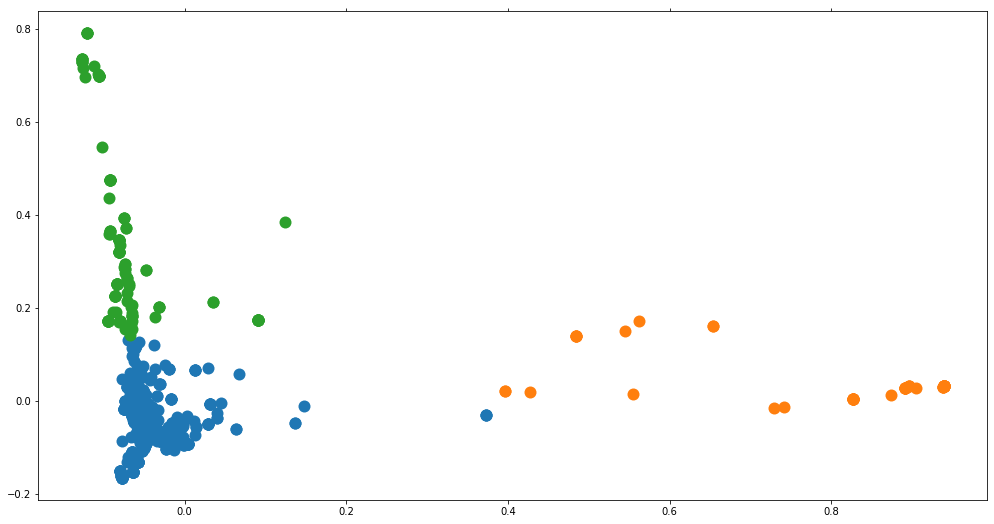

In [18]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

xs, ys = X[:, 0], X[:, 1]

#create data frame that has the result of the MDS plus the cluster numbers and titles
df2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=labelList)) 

#group by cluster
groups = df2.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    #ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
    #        label=cluster_names[name], color=cluster_colors[name], 
    #        mec='none')
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
             mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
#ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
    #ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

For n_clusters = 2 The average silhouette_score is : 0.8374173225018036
For n_clusters = 3 The average silhouette_score is : 0.783526791203618
For n_clusters = 4 The average silhouette_score is : 0.7683459204343507
For n_clusters = 5 The average silhouette_score is : 0.7757792342813097
For n_clusters = 6 The average silhouette_score is : 0.6980154892599374


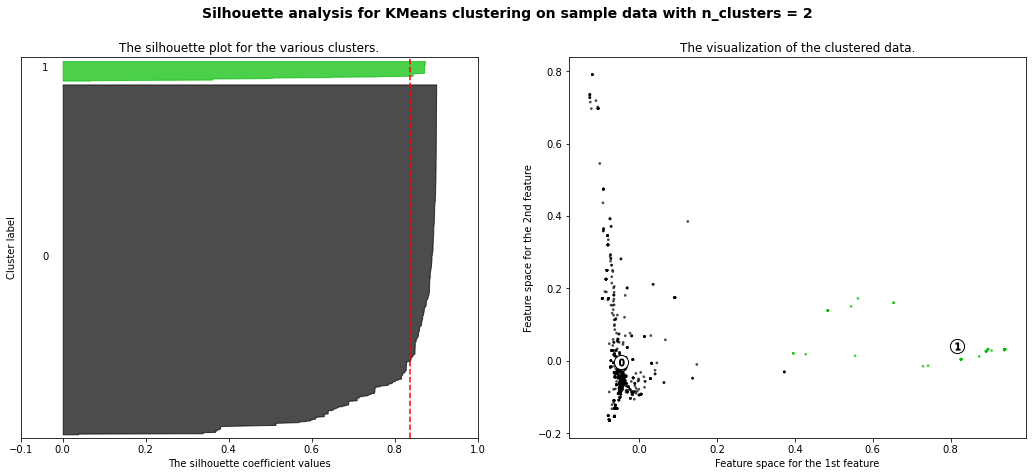

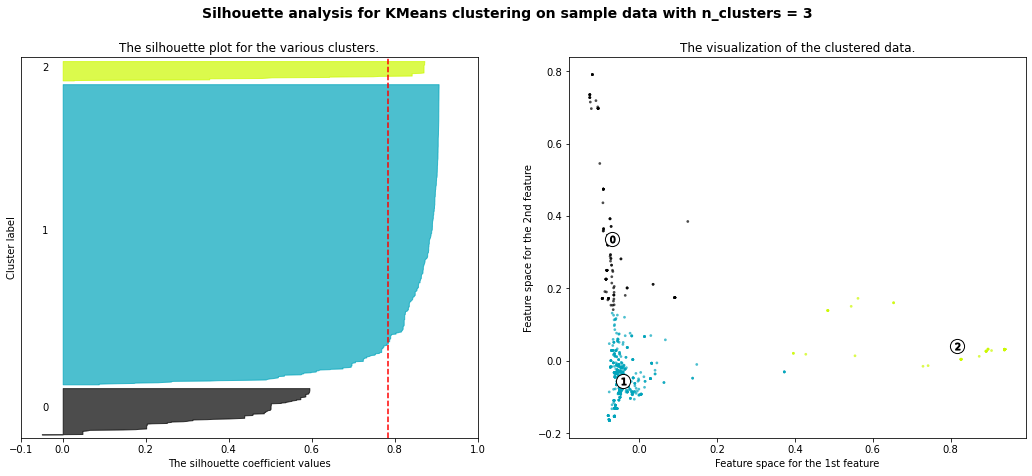

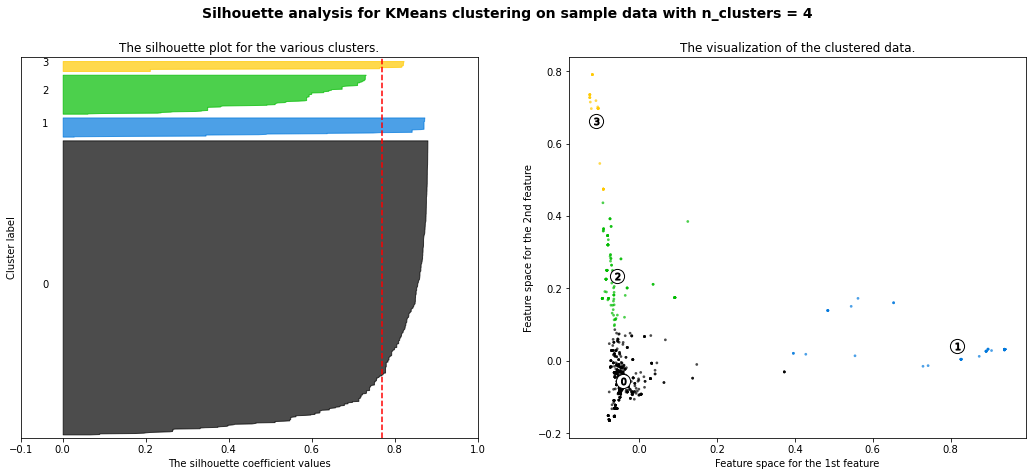

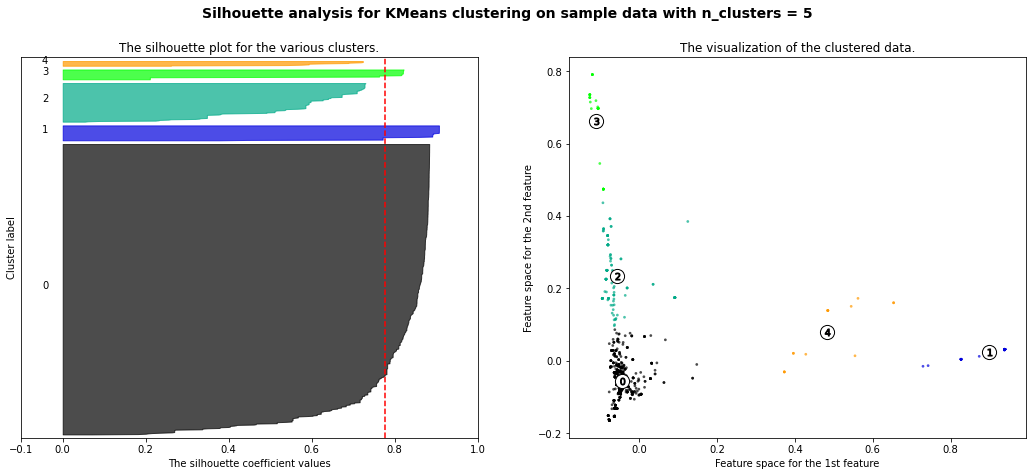

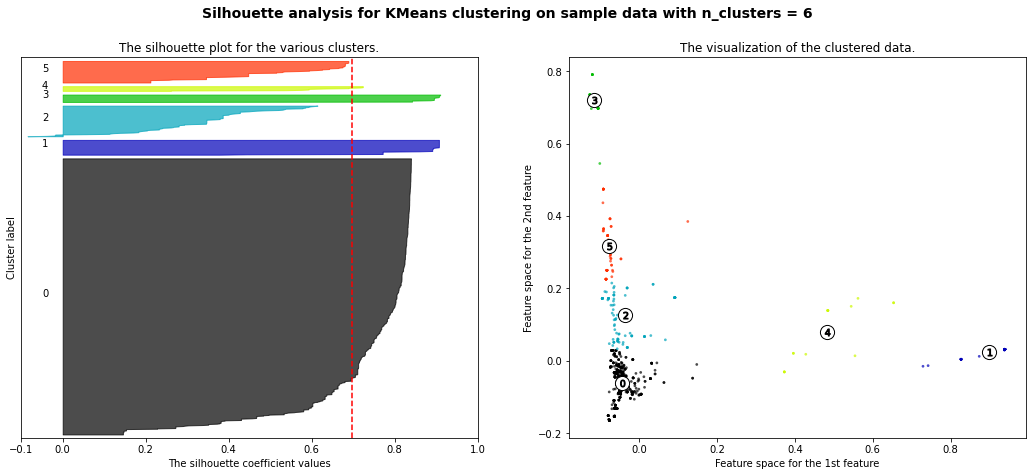

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary
from gensim.test.utils import get_tmpfile
import numpy
from gensim.matutils import hellinger
import  csv

df.sort_values(by=['publish_year'], inplace=True)

year_slice_df = df.groupby(['publish_year']).size().reset_index(name='counts')

tmp_fname = get_tmpfile(base_directory+"/dictionary.txt")
dictionary = Dictionary(df['abstract'])

# Filter out words that occur less than 50 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

dictionary.save_as_text(tmp_fname)
print("dictionary saved at",tmp_fname)

corpus = [dictionary.doc2bow(text) for text in df['abstract']]

with open(base_directory+"/corpus.csv","w") as f:
    wr = csv.writer(f)
    wr.writerows(corpus)
print("corpus saved")

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(year_slice_df)

In [ ]:
from gensim.models import ldaseqmodel
from gensim.test.utils import datapath

number_of_topics = 4
time_slice = year_slice_df['counts'].tolist()
print(time_slice)
%time ldaseq = ldaseqmodel.LdaSeqModel(
    corpus=corpus, 
    id2word=dictionary, 
    time_slice=time_slice, 
    num_topics=number_of_topics, 
    alphas=0.01,
    chain_variance = 0.005,
    passes=5,
    lda_inference_max_iter=25, 
    em_min_iter=6, 
    em_max_iter=20, 
    chunksize=100
)
print("model created")


In [ ]:
from IPython.display import display

def get_topic_df(topic_id,num_words):
  topics = ldaseq.print_topic_times(topic=topic_id,top_terms=num_words)
  topic_slice = 0
  data = {}
  for year in year_slice_df['publish_year']:
    topic_words = topics[topic_slice]
    word_list = []
    for word,score in topic_words:
      word_list.append(word)
    data[year]=word_list
    topic_slice += 1
  return pd.DataFrame(data)

# Create DataFrame 

for topic in range(0,number_of_topics):
  print("Topic",topic)
  display(get_topic_df(topic,10))

In [ ]:
temp_file = get_tmpfile(base_directory+"/model")
ldaseq.save(temp_file)
print("model saved")



In [ ]:
with open(base_directory+"/corpus-embeddings.csv","w") as f:
    wr = csv.writer(f)
    for doc in corpus:
        embedding = ldaseq[doc]
        wr.writerow(embedding)
print("corpus embeddings saved")